In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')  

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('seaborn-talk')

## <font color='steelblue'>Report of Activities in support of the IBA-IOBS Project: "Proton Therapy vs. Traditional Radiation therapy: Total Cost of care, Effects on Survival, liklihood of complications and Qualtiy of Life."</font>

Below we will present

* a timeline of the of the steps taken to acquire the SEER-Medicare data
    * All necessary steps have been taken; IOBS has been informed that we can expect delivery within 2-4 weeks.
* a brief description of a commecial claims data source, including the results of pricing inquiries.
    * Truven Health, deidentified commercial (and Medicare) claims data
* a descrition of the SEER-Medicare data files and their format.

as well as preliminary work and results on Patient Matching using KDTrees; a more direct approach to patient matching than the traditional Propensity Score Matching methods. Needed as a foundational step to make meaningful comparisons between Proton Therapy patients and their traditional radiation thearpy counterparts.

* Left-sided breast cancer patients
* prostate cancer patients

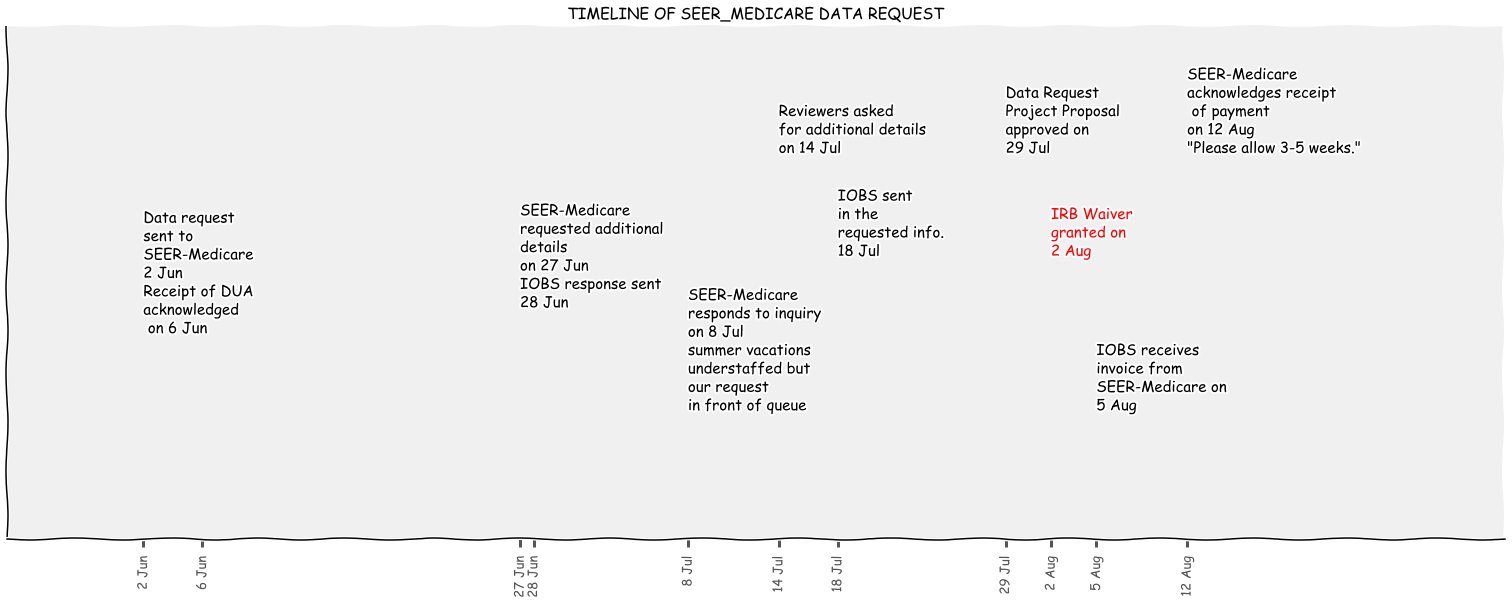

In [97]:
import matplotlib.pyplot as plt
import numpy as np

with plt.xkcd():
    # Based on "Stove Ownership" from XKCD by Randall Monroe
    # http://xkcd.com/418/
    fig = plt.figure()
    ax = fig.add_axes((0.0, 0.0, 2, 1))
    #ax.bar([-0.325, 1.0 - 0.325], [0, 100], 0.25)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks([0, .13, .83, .86, 1.2,
                   1.4, 1.53, 1.9, 2.0,
                  2.1, 2.3])
    ax.set_xlim([-0.3, 3])
    ax.set_ylim([0, 2])
    ax.set_xticklabels(['2 Jun', '6 Jun', '27 Jun', '28 Jun','8 Jul', 
                       '14 Jul', '18 Jul', '29 Jul', '2 Aug',
                       '5 Aug', '12 Aug'],
                      rotation=90)
    plt.yticks([])

    ax.text(0,.8, 'Data request\nsent to\nSEER-Medicare\n2 Jun\nReceipt of DUA\n' +
    'acknowledged\n on 6 Jun', 
           style='italic',fontsize=15)
    
    
    ax.text(.83,.9, 'SEER-Medicare\nrequested additional\n' +
    'details\non 27 Jun\nIOBS response sent\n28 Jun', 
           style='italic',fontsize=15)
    
    ax.text(1.2, .5, 'SEER-Medicare\nresponds to inquiry\non 8 Jul\nsummer vacations\nunderstaffed but\n' + 
           'our request\nin front of queue',
           style='italic',fontsize=15)
    
    ax.text(1.4, 1.5,'Reviewers asked\nfor additional details\non 14 Jul',
           style='italic',fontsize=15)
    
    
    ax.text(1.53, 1.1, 'IOBS sent\nin the\nrequested info.\n18 Jul',
           style='italic',fontsize=15)
    
    ax.text(1.9,1.5,'Data Request\nProject Proposal\napproved on\n' + 
           '29 Jul',style='italic',fontsize=15)
    
    
    ax.text(2.0, 1.1, 'IRB Waiver\ngranted on\n2 Aug',
           style='italic',fontsize=15,color='red')
    
    
    ax.text(2.1, .5, 'IOBS receives\ninvoice from\n' + 
           'SEER-Medicare on\n5 Aug',
           style='italic',fontsize=15)
    
    
    ax.text(2.3, 1.5, 'SEER-Medicare\nacknowledges receipt\n of payment\n' +
           'on 12 Aug\n"Please allow 3-5 weeks."',
           style='italic',fontsize=15)
    
    
    plt.annotate(
        'THE DAY I REALIZED\nI COULD COOK BACON\nWHENEVER I WANTED',
        xy=(70, 1), arrowprops=dict(arrowstyle='->'), xytext=(15, -10))
    
    plt.title("TIMELINE OF SEER_MEDICARE DATA REQUEST")

#    fig.text(
    #    0.5, 0.05,
    #    '"The Data So Far" from xkcd by Randall Monroe',
     #   ha='center')

plt.savefig('timeline.pdf',format='pdf')
plt.show()

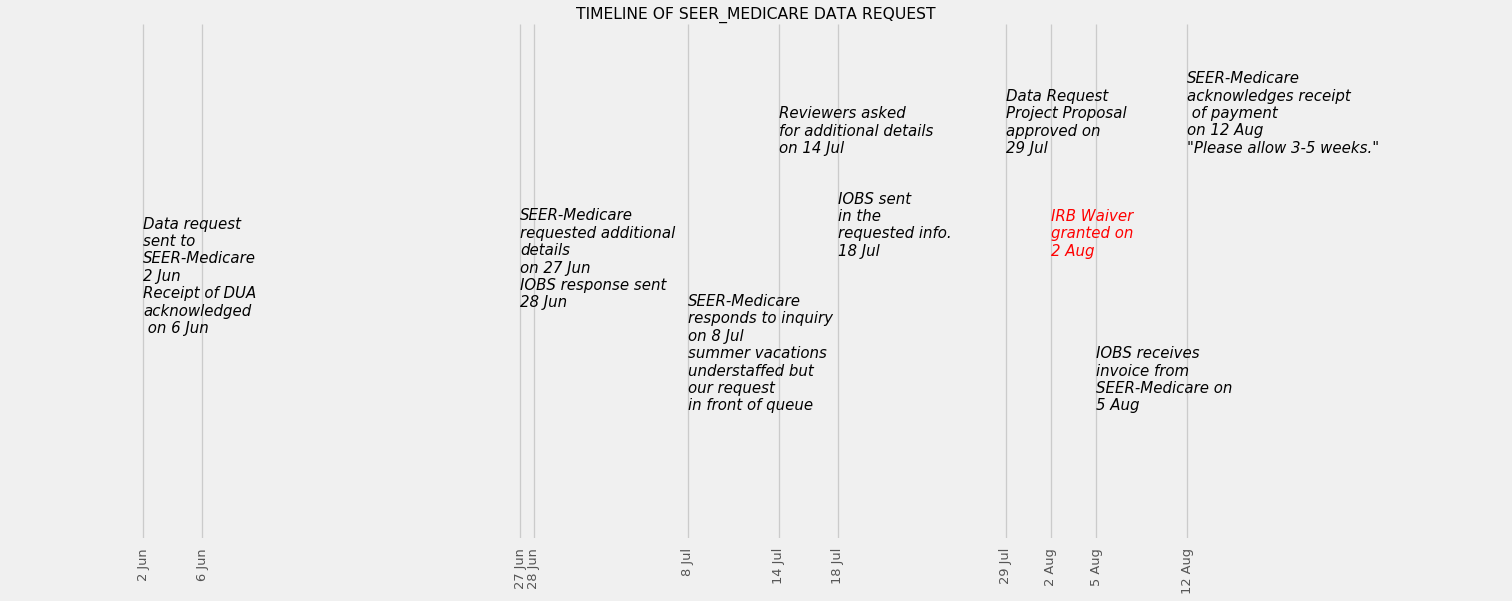

In [93]:
# Based on "Stove Ownership" from XKCD by Randall Monroe
    # http://xkcd.com/418/
fig = plt.figure()
ax = fig.add_axes((0.0, 0.0, 2, 1))
    #ax.bar([-0.325, 1.0 - 0.325], [0, 100], 0.25)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks([0, .13, .83, .86, 1.2,
                   1.4, 1.53, 1.9, 2.0,
                  2.1, 2.3])
ax.set_xlim([-0.3, 3])
ax.set_ylim([0, 2])
ax.set_xticklabels(['2 Jun', '6 Jun', '27 Jun', '28 Jun','8 Jul', 
                       '14 Jul', '18 Jul', '29 Jul', '2 Aug',
                       '5 Aug', '12 Aug'],
                      rotation=90)
plt.yticks([])

ax.text(0,.8, 'Data request\nsent to\nSEER-Medicare\n2 Jun\nReceipt of DUA\n' +
    'acknowledged\n on 6 Jun', 
           style='italic',fontsize=15)
    
    
ax.text(.83,.9, 'SEER-Medicare\nrequested additional\n' +
    'details\non 27 Jun\nIOBS response sent\n28 Jun', 
           style='italic',fontsize=15)
    
ax.text(1.2, .5, 'SEER-Medicare\nresponds to inquiry\non 8 Jul\nsummer vacations\nunderstaffed but\n' + 
           'our request\nin front of queue',
           style='italic',fontsize=15)
    
ax.text(1.4, 1.5,'Reviewers asked\nfor additional details\non 14 Jul',
           style='italic',fontsize=15)
    
    
ax.text(1.53, 1.1, 'IOBS sent\nin the\nrequested info.\n18 Jul',
           style='italic',fontsize=15)
    
ax.text(1.9,1.5,'Data Request\nProject Proposal\napproved on\n' + 
           '29 Jul',style='italic',fontsize=15)
    
    
ax.text(2.0, 1.1, 'IRB Waiver\ngranted on\n2 Aug',
           style='italic',fontsize=15,color='red')
    
    
ax.text(2.1, .5, 'IOBS receives\ninvoice from\n' + 
           'SEER-Medicare on\n5 Aug',
           style='italic',fontsize=15)
    
    
ax.text(2.3, 1.5, 'SEER-Medicare\nacknowledges receipt\n of payment\n' +
           'on 12 Aug\n"Please allow 3-5 weeks."',
           style='italic',fontsize=15)
    
    
plt.title("TIMELINE OF SEER_MEDICARE DATA REQUEST")

#    fig.text(
    #    0.5, 0.05,
    #    '"The Data So Far" from xkcd by Randall Monroe',
     #   ha='center')

#plt.show()

In [94]:
plt.show()